[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/quickstarters/blob/main/competitions/causality-discovery/supervised_baseline_submission/supervised_baseline_submission.ipynb)

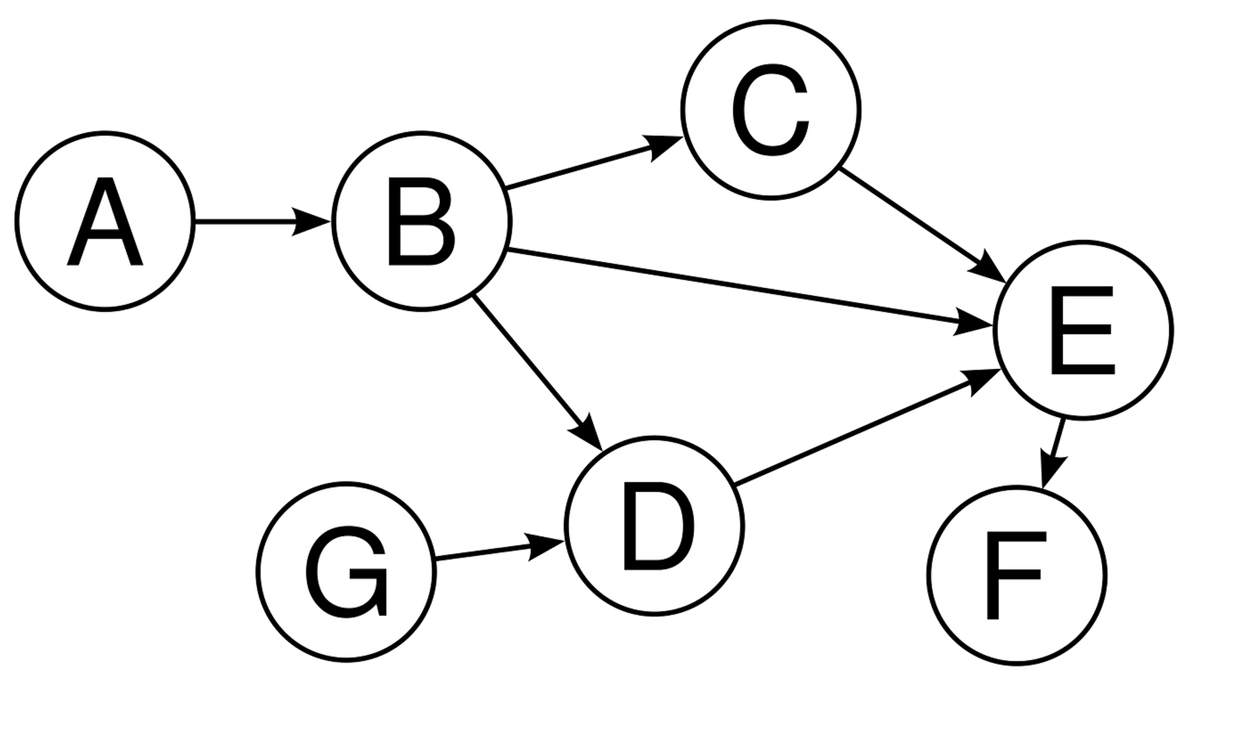

## Causal Discovery Competition - **Supervised** Baseline Notebook

The purpose of this notebook is twofold: to introduce contestants to the competition and to provide a simple **supervised learning** submission based on the concepts explained in the *Supervised Causal Discovery Tutorial*.

The main idea behind the proposed solution is to transform the initial training set, which consists of multiple datasets with related causal graphs, into a standard `(X, y)` dataset suitable for setting up a classification problem. The transformed dataset contains one row for each variable from each of the initial datasets. This transformation is necessary because the competition's scoring metric requires an accurate determination of whether a variable in a dataset is a confounder, a collider, a mediator, and so on. Therefore, we frame it as a multiclass classification problem, where the goal is to predict the category of each variable.

The process includes the following steps:

1. **Transforming the training data**: The initial training data, which includes multiple datasets and their associated graphs, is transformed into a single, large, standardized `(X_train, y_train)` dataset for supervised classification. Each variable in the original datasets (except `X` and `Y`) becomes a row in this new dataset. These rows are described by different features and are class labeled according to one of the 8 competition categories (such as confounder, collider, mediator, etc.). This step effectively performs *variable embedding*.

2. **Model training**: A classification algorithm is trained using the `(X_train, y_train)` dataset.

3. **Test data transformation**: The test datasets are transformed in the same way as the training data, resulting in `X_test`.

4. **Prediction**: The classification algorithm predicts `y_test` based on `X_test`.

5. **Submission**: The predictions are formatted according to the competition requirements to reconstruct the test graphs, and the submission is created.

### Preliminary step

In [ ]:
%pip install crunch-cli --upgrade

In [ ]:
# update the token via https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook

!crunch setup --notebook causality-discovery default --token aaaabbbbccccddddeeeeffff

### Imports

In [19]:
"""
This is a basic example of what you need to do to enter the competition.
The code will not have access to the internet (or any socket related operation).
"""

import functools
import os
import typing

import joblib
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ttest_rel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

In [20]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


### Useful Functions

Here we define some functions useful to prepare the submission.

This is the core of the solution's code, which reads one record at a time, applies the PC algorithm, ensures that the result is a DAG, and then puts the result into a single data frame in the required format, ready for submission.

In [28]:
def graph_nodes_representation(graph, nodelist):
    """
    Create an alternative representation of a graph which is hashable
    and equivalent graphs have the same hash.

    Python cannot PROPERLY use nx.Graph/DiGraph as key for
    dictionaries, because two equivalent graphs with just different
    order of the nodes would result in different keys. This is
    undesirable here.

    So here we transform the graph into an equivalent form that is
    based on a specific nodelist and that is hashable. In this way,
    two equivalent graphs, once transformed, will result in identical
    keys.

    So we use the following trick: extract the adjacency matrix
    (with nodes in a fixed order) and then make a hashable thing out
    of it, through tuple(array.flatten()):
    """

    # This get the adjacency matrix with nodes in a given order, as
    # numpy array (which is not hashable):
    adjacency_matrix = nx.adjacency_matrix(graph, nodelist=nodelist).todense()

    # This transforms the numpy array into a hashable object:
    hashable = tuple(adjacency_matrix.flatten())

    return hashable

In [29]:
def create_graph_label():
    """
    Create a dictionary from graphs to labels, in two formats.
    """
    graph_label = {
        nx.DiGraph([("X", "Y"), ("v", "X"), ("v", "Y")]): "Confounder",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("Y", "v")]): "Collider",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("v", "Y")]): "Mediator",
        nx.DiGraph([("X", "Y"), ("v", "X")]):             "Cause of X",
        nx.DiGraph([("X", "Y"), ("v", "Y")]):             "Cause of Y",
        nx.DiGraph([("X", "Y"), ("X", "v")]):             "Consequence of X",
        nx.DiGraph([("X", "Y"), ("Y", "v")]):             "Consequence of Y",
        nx.DiGraph({"X": ["Y"], "v": []}):                "Independent",
    }

    nodelist = ["v", "X", "Y"]

    # This is an equivalent alternative to graph_label but in a form
    # for which two equivalent graphs have the same key:
    adjacency_label = {
        graph_nodes_representation(graph, nodelist): label
        for graph, label in graph_label.items()
    }

    return graph_label, adjacency_label

In [30]:
def get_labels(adjacency_matrix, adjacency_label):
    """
    Transform an adjacency_matrix (as pd.DataFrame) into a dictionary of variable:label
    """

    result = {}
    for variable in adjacency_matrix.columns.drop(["X", "Y"]):
        submatrix = adjacency_matrix.loc[[variable, "X", "Y"], [variable, "X", "Y"]]  # this is not hashable
        key = tuple(submatrix.values.flatten())  # this is hashable and a compatible with adjacency_label
    
        result[variable] = adjacency_label[key]

    return result

In [31]:
def pearson_correlation(dataset):
    """
    Given a dataset, we compute the correlation-based features for each
    varibale, which are the correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs
    of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr().drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "corr(v,X)": dataset[[variable, "X"]].corr().loc[variable, "X"],
            "corr(v,Y)": dataset[[variable, "Y"]].corr().loc[variable, "Y"],
            "max(corr(v, others))": tmp.max(),
            "min(corr(v, others))": tmp.min(),
            "mean(corr(v, others))": tmp.mean(),
            "std(corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["corr(X,Y)"] = dataset[["X", "Y"]].corr().loc["X", "Y"]

    # pearsonr is NaN when the variance is 0, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [32]:
def ttest(dataset, pvalue_threshold=0.05):
    """
    Given a dataset, this function computes the t-test between the
    values each variable v and X, Y. The t value and the result of the
    t-test with a given pvalue_threshold, are used to create features
    to describe/embed v, as well as the t-test result between the
    values of X and Y.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        ttest_vX = ttest_rel(dataset[variable], dataset["X"])
        ttest_vY = ttest_rel(dataset[variable], dataset["Y"])

        df.append({
            "variable": variable,
            "ttest(v,X)": ttest_vX.statistic,
            f"pvalue(ttest(v,X))<={pvalue_threshold}": (ttest_vX.pvalue <= pvalue_threshold).astype(float),
            "ttest(v,Y)": ttest_vY.statistic,
            f"pvalue(ttest(v,Y))<={pvalue_threshold}": (ttest_vY.pvalue <= pvalue_threshold).astype(float),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    ttest_XY = ttest_rel(dataset["X"], dataset["Y"])
    df["ttest(X,Y)"] = ttest_XY.statistic
    df[f"pvalue(ttest(X,Y))<={pvalue_threshold}"] = (ttest_XY.pvalue <= pvalue_threshold).astype(float)

    # some the ttest returns NaN when the variance is 0, so we fill with 0:
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [33]:
def mutual_information(dataset):
    """
    Given a dataset, we compute the mutual-information-based features
    for each varibale, which are the correlation between that variable
    X and Y, as well as summary statistics (max, min, mean, std) of
    all pairs of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = mutual_info_regression(dataset.drop(columns=[variable]), dataset[variable])

        df.append({
            "variable": variable,
            "MI(v,X)": mutual_info_regression(dataset[[variable]], dataset["X"], discrete_features=False)[0],
            "MI(v,Y)": mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0],
            "max(MI(v, others))": tmp.max(),
            "min(MI(v, others))": tmp.min(),
            "mean(MI(v, others))": tmp.mean(),
            "std(MI(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["MI(X,Y)"] = mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [34]:
def label(adjacency_matrix):
    """
    Given a graph as adjacency_matrix, create the class labels of each variable.
    """

    adjacency_graph, adjacency_label = create_graph_label()
    labels = get_labels(adjacency_matrix, adjacency_label)
    variables = adjacency_matrix.columns.drop(["X", "Y"])

    df = pd.DataFrame({
        "variable": variables,
        "label": [labels[variable] for variable in variables],
    })
    df["dataset"] = adjacency_matrix.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

### Column Creation

In [35]:
def create_some_columns(names_datasets, function):
    """
    Apply an embedding function to a list of datasets.
    """

    df = []
    for name, dataset in tqdm(names_datasets.items(), mininterval=10):
        dataset = names_datasets[name]
        dataset.name = name
    
        try:
            df_dataset = function(dataset)
        except ValueError as e:
            print(name, e)
            raise NotImplementedError

        df_dataset["dataset"] = name
        df.append(df_dataset)

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [36]:
def create_some_columns_parallel(names_datasets, function, n_jobs=-1):
    """
    Apply an embedding function to a list of datasets.

    Parallel version.
    """

    def f(name, dataset, function):
        dataset.name = name
        df_dataset = function(dataset)
        df_dataset["dataset"] = name
        return df_dataset

    df = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(f)(name, dataset, function)
        for name, dataset in tqdm(names_datasets.items(), mininterval=10)
    )

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [37]:
def create_all_columns(functions_names_datasets, n_jobs=-1):
    """
    given a dictionary of {function1:names, function2:names,...} apply
    the desired functions to the list of datasets and merge all of them
    in a single X_y_group dataframe.
    """

    columns = []
    for function, names_datasets in functions_names_datasets.items():
        print(f"set: {function.__name__}")

        if n_jobs != 1:
            feature_set = create_some_columns_parallel(names_datasets, function, n_jobs=n_jobs)
        else:
            feature_set = create_some_columns(names_datasets, function)

        columns.append(feature_set)

    # Merge all feature sets into a single dataframe:
    columns = functools.reduce(
        lambda left, right: pd.merge(left, right, on=["dataset", "variable"]),
        columns,
    )

    return columns

### Submission Creation

In [38]:
def create_submission(X_y_pred_test):
    """
    From the predicted test set, for each dataset, take predicted
    classes of all variables, create the adjacency matrix, then create
    the submission in the requested format.
    """

    submission = {}
    for name, prediction in tqdm(X_y_pred_test.groupby("dataset"), delay=10):
        variables_labels = prediction[["variable", "label_predicted"]].set_index("variable")
        variables = variables_labels.index.tolist()
        variables_all = ["X", "Y"] + variables

        adjacency_matrix = pd.DataFrame(index=variables_all, columns=variables_all)
        adjacency_matrix.index.name = "parent"
        adjacency_matrix[:] = 0
        adjacency_matrix.loc["X", "Y"] = 1

        for v in variables:
            l = variables_labels.loc[v].item()
            if l == "Cause of X":
                adjacency_matrix.loc[v, "X"] = 1
            elif l == "Cause of Y":
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Consequence of X":
                adjacency_matrix.loc["X", v] = 1
            elif l == "Consequence of Y":
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Confounder":
                adjacency_matrix.loc[v, "X"] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Collider":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Mediator":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Confounder":
                pass

        for i in variables_all:
            for j in variables_all:
                submission[f'{name}_{i}_{j}'] = int(adjacency_matrix.loc[i, j])

    return submission

### CrunchDAO Code Interface

In [25]:
def train(
    X_train: typing.Dict[str, pd.DataFrame],
    y_train: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    # id_column_name: str,
    # prediction_column_name: str,
    # has_gpu: bool,
) -> None:
    # 1) Create the variable embedding:
    X_y_group_train_pathname = "/tmp/X_y_group_train.parquet"
    try:
        print(f"Loading {X_y_group_train_pathname}")
        X_y_group_train = pd.read_parquet(X_y_group_train_pathname)
    except FileNotFoundError:
        print("Creating X_y_group_train")
        names_datasets_train = X_train
        names_graphs_train = y_train
        X_y_group_train = create_all_columns(
            {
                pearson_correlation: names_datasets_train,
                ttest: names_datasets_train,
                mutual_information: names_datasets_train,  # comment this line to greatly reduce computation
                label: names_graphs_train,
            },
            n_jobs=-1,
        )

        # 2) Massage X_y_group_train to prepare what is needed by the model:
        print("Adding numeric labels y") # sklearn wants numeric labels
        le = LabelEncoder()
        le.classes_ = np.array([
            'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
            'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
        ])
        X_y_group_train["y"] = le.transform(X_y_group_train["label"])

        # reordering columns:
        X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]
        display(X_y_group_train)

        print("Saving X_y_group_train")
        os.makedirs(os.path.dirname(X_y_group_train_pathname), exist_ok=True)
        X_y_group_train.to_parquet(X_y_group_train_pathname)

    print("Extracting X_train, y_train, and group")
    X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
    y_train = X_y_group_train["y"]
    group_train = X_y_group_train["dataset"]

    # Model:
    model = RandomForestClassifier(n_estimators=100, max_depth=11, n_jobs=-1, class_weight="balanced")
    model.fit(X_train, y_train)

    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )

In [26]:
# Uncomment what you need!
def infer(
    X_test: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    prediction_column_name: str,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    names_datasets_test = X_test
    X_group_test = create_all_columns(
        {
            pearson_correlation: names_datasets_test,
            ttest: names_datasets_test,
            mutual_information: names_datasets_test,  # comment this line to greatly reduce computation
        },
        n_jobs=-1,
    )

    X_test = X_group_test.drop(columns=["dataset", "variable"])
    y_predicted = model.predict(X_test)
    X_y_pred_test = X_group_test
    X_y_pred_test["y_predicted"] = y_predicted

    le = LabelEncoder()
    le.classes_ = np.array([
        'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
        'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
    ])

    X_y_pred_test["label_predicted"] = le.inverse_transform(y_predicted)

    submission = create_submission(X_y_pred_test)

    return pd.DataFrame(
        submission.items(),
        columns=[
            id_column_name,
            prediction_column_name
        ]
    )

### Local Testing

Before submitting your notebook, please make sure that it works locally so that you do not waste compute time. The `crunch.test()` will execute your code with the same logic as it will in the cloud environment.

In [ ]:
crunch.test(
    no_determinism_check=True
)

print("Download this notebook and submit it to the platform: https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook")